# Experiments with Fitzpatrick17K

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [45]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
from kerasmodels import CreateGenerator, CNNModel
import attacks
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [46]:
db = "FITZ"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [47]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create image generator

In [48]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [49]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.
Found 864 validated image filenames belonging to 2 classes.


## Training

In [50]:
import torch # Due to keras version
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[300, 300, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
        
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=32, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid", kernel_initializer="glorot_uniform", name="classifier"))
        
model.compile(Adam(learning_rate= 0.0001), loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     5,607,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,886,273 (22.45 MB)

 Trainable params: 5,885,761 (22.45 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.5619 - loss: 0.7948 - val_accuracy: 0.5081 - val_loss: 1.0879
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.5997 - loss: 0.6775 - val_accuracy: 0.5856 - val_loss: 0.7156
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6107 - loss: 0.6588 - val_accuracy: 0.5660 - val_loss: 0.7282
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6508 - loss: 0.6267 - val_accuracy: 0.6192 - val_loss: 0.7009
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6367 - loss: 0.6303 - val_accuracy: 0.6262 - val_loss: 0.6854
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6840 - loss: 0.5921 - val_accuracy: 0.6030 - val_loss: 1.0052
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6653 - loss: 0.6053 - val_accuracy: 0.6250 - val_loss: 0.7613
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6847 - loss: 0.5728 - val_accurac

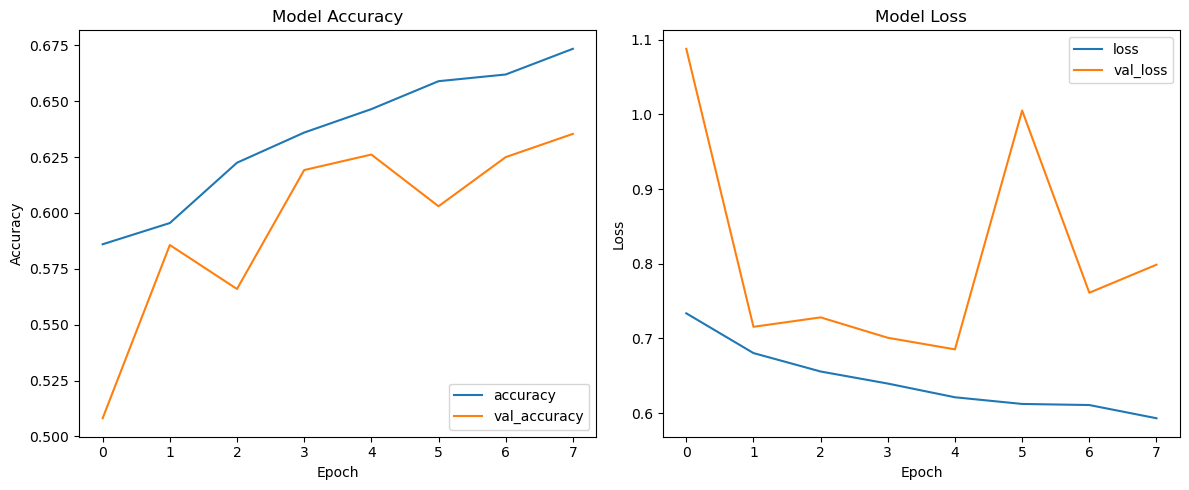

In [51]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history["accuracy"], label="accuracy")
ax[0].plot(history.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Model Accuracy")

# Loss
ax[1].plot(history.history["loss"], label="loss")
ax[1].plot(history.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Model Loss")

plt.tight_layout()
plt.show()

## Evaluation

In [52]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6652 - loss: 0.6627
Test Loss 0.6551120281219482
Test Accuracy 0.6435185074806213


In [53]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.66      0.59      0.63       432
           1       0.63      0.69      0.66       432

    accuracy                           0.64       864
   macro avg       0.64      0.64      0.64       864
weighted avg       0.64      0.64      0.64       864



# Adversarial attacks

## Random Noise

True label: 1
Prediction: [[0.6121883]]
Prediction class: ['1']
Adversarial Prediction: [[0.5479794]]
Adversarial Predicted Class: ['1']


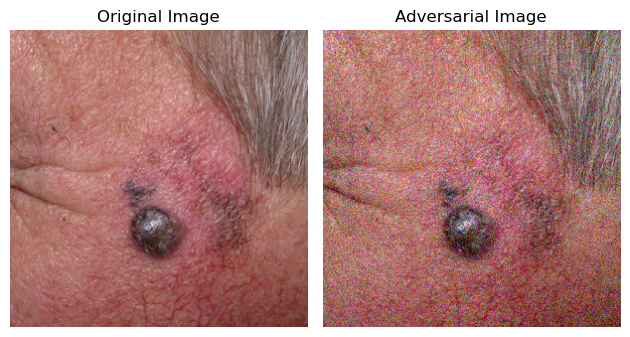

In [82]:
np.random.seed(42)
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.16
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [83]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [84]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.2824074074074074
RN TN Success rate: 0.16203703703703703
RN FP Success rate: 0.12037037037037036


## FGSM

True label: 1
Prediction: [[0.6121883]]
Prediction class: ['1']
Adversarial Prediction: [[0.06083249]]
Adversarial Predicted Class: ['0']


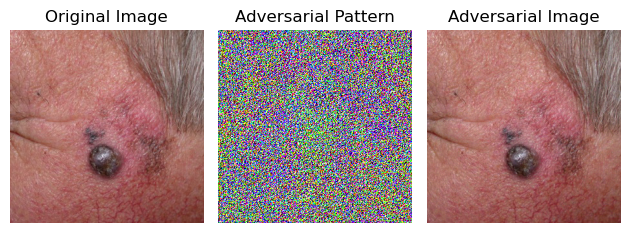

In [57]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.01
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [58]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [59]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.6192129629629629
FGSM TN Success rate: 0.28125
FGSM FP Success rate: 0.33796296296296297


## Saliency Map Attack

True label: 1
Prediction: [[0.6121883]]
Prediction class: ['1']
Adversarial Prediction: [[0.89662206]]
Adversarial Predicted Class: ['1']


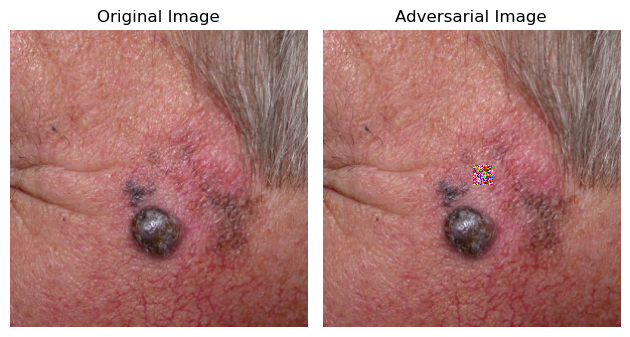

In [88]:
filepath = f"{root}data/ede3cf4179d6e3de2764edecc494c118.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.7
patch_size=20
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [89]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [90]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.2349537037037037
SM TN Success rate: 0.22569444444444445
SM FP Success rate: 0.009259259259259259


## Data export for analysis

In [91]:
test_df.to_csv(f"{root}exp/test_df_Fitzpatrick17K_CNN.csv", index=False)